## Подготовка

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с разряженными матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from catboost import CatBoostClassifier, CatBoost, Pool

# Визуализация
import matplotlib.pyplot as plt

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [13]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

__Open dataset__

In [14]:
data = pd.read_csv('data/retail_train.csv')
test = pd.read_csv('data/retail_test1.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

In [15]:
data.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [16]:
test.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0


In [17]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

__Train test split__

In [199]:
# Данные для тренировки и валидации matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# Данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# Данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

__Prefilter items__

In [200]:
popularity = data.groupby('item_id')['quantity'].sum().reset_index().sort_values('quantity', ascending=False).reset_index()

In [201]:
popularity['quantity'].head(25)

0     199684264
1      16911359
2      12946508
3       2578976
4       1645146
5       1246340
6        453293
7        430940
8        394613
9        295610
10       211085
11       168661
12       118129
13        70125
14        58208
15        47710
16        35911
17        35816
18        28384
19        27071
20        26912
21        20134
22        19706
23        18559
24        15840
Name: quantity, dtype: int64

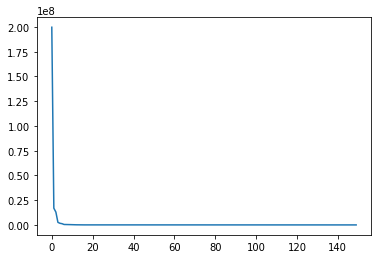

In [202]:
_n = 150
_ = plt.plot(popularity['quantity'].head(_n).index, popularity['quantity'].head(_n))

In [203]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features,
    take_n_popular=12000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/Users/blaze/Documents/Notebooks/recsys/recsys-homework/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 12001


__Warm start__

In [186]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

__Init main recommender__

In [21]:
recommender = MainRecommender(data_train_matcher)

100%|██████████| 5001/5001 [00:00<00:00, 19423.02it/s]


__Eval recall of matching__

In [22]:
ACTUAL_COL = 'actual'

In [23]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [24]:
def eval_recall(df_result, recommend_model, N):
    result_col_name = 'result'
    target_col_name = USER_COL
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N), axis=1).mean()

__Generate train data__

In [25]:
N_PREDICT = 200

In [26]:
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [27]:
df_match_candidates['candidates'] = \
    df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [28]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [29]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_items.head(3)

0    1105426
0    1097350
0     879194
Name: item_id, dtype: int64

In [30]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(2)

,user_id,item_id
0,2070,1105426
0,2070,1097350


In [31]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1 # То есть куплено
df_ranker_train.head(3)

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1


In [32]:
# Добавяем не купленные товары (target = 0)
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# Чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

# Заполняем пропуски
df_ranker_train['target'].fillna(0, inplace= True)

In [33]:
df_ranker_train.target.value_counts()

0.0    397661
1.0     17984
Name: target, dtype: int64

In [34]:
df_ranker_train.head(3)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0


In [35]:
df_ranker_train_copy = df_ranker_train.copy()

### Feature engineering

#### User features

In [36]:
new_user_features = user_features.copy()
new_user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


__Average bill (Средний чек)__

In [37]:
data.head(1)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0


In [38]:
avb_data = data[['user_id', 'basket_id', 'sales_value']].copy()
avb_data.head(5)

,user_id,basket_id,sales_value
0,2375,26984851472,1.39
1,2375,26984851472,0.82
2,2375,26984851472,0.99
3,2375,26984851472,1.21
4,2375,26984851472,1.50


In [39]:
average_bill = avb_data.groupby('basket_id').agg('mean').groupby('user_id').agg('mean')
average_bill

,sales_value
user_id,
1.0,2.726818
2.0,3.281768
3.0,3.268026
4.0,4.044173
5.0,4.368017
...,...
2496.0,7.811230
2497.0,3.981373
2498.0,3.855324


In [40]:
new_user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [41]:
average_bill_user_features = average_bill.loc[new_user_features['user_id'], 'sales_value']
average_bill_user_features.head(5)

user_id
1      2.726818
7      2.989986
8      4.734543
13    19.434575
16     4.401541
Name: sales_value, dtype: float64

In [42]:
new_user_features.shape, average_bill_user_features.shape

((801, 8), (801,))

In [43]:
new_user_features['average_bill'] = average_bill_user_features.to_numpy()
new_user_features.head(5)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,average_bill
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.726818
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.989986
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,4.734543
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,19.434575
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,4.401541


__Billing rate n/month (Количество покупок в месяц)__

In [44]:
data.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [45]:
br_data = data.copy()
br_data['count'] = 1
br_data_basket_id_mean = br_data.groupby('basket_id').agg('mean')
br_data_basket_id_mean.head(5)

,user_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,count
basket_id,,,,,,,,,,,,
26984851472,2375.0,1.0,2.463398e+06,1.000000,1.182000,364.0,-0.258000,1631.0,1.0,0.0,0.0,1.0
26984851516,2375.0,1.0,3.328273e+06,1.166667,2.071667,364.0,-0.543333,1642.0,1.0,0.0,0.0,1.0
26984896261,1364.0,1.0,9.160190e+05,1.000000,2.274000,31742.0,-0.436000,1520.0,1.0,0.0,0.0,1.0
26984905972,1130.0,1.0,9.686606e+05,1.800000,0.510000,31642.0,-0.416000,1340.0,1.0,0.0,0.0,1.0
26984945254,1173.0,1.0,9.599073e+05,1.333333,1.176667,412.0,0.000000,2042.0,1.0,0.0,0.0,1.0


In [46]:
user_num_baskets = br_data_basket_id_mean[['user_id', 'count']].groupby('user_id').agg('count')
user_num_baskets

,count
user_id,
1.0,79
2.0,44
3.0,45
4.0,30
5.0,38
...,...
2496.0,60
2497.0,215
2498.0,158


In [47]:
num_days = data['day'].max()
num_days

663

In [48]:
days_per_month = 30
num_months = num_days / days_per_month
num_months

22.1

In [49]:
user_billings_per_month = user_num_baskets / num_months
user_billings_per_month

,count
user_id,
1.0,3.574661
2.0,1.990950
3.0,2.036199
4.0,1.357466
5.0,1.719457
...,...
2496.0,2.714932
2497.0,9.728507
2498.0,7.149321


In [50]:
new_user_features.head(5)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,average_bill
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.726818
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.989986
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,4.734543
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,19.434575
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,4.401541


In [51]:
billings_per_month = user_billings_per_month.loc[new_user_features['user_id']]
billings_per_month

,count
user_id,
1,3.574661
7,2.307692
8,4.705882
13,11.447964
16,4.343891
...,...
2494,1.357466
2496,2.714932
2497,9.728507


In [52]:
new_user_features['billings_per_month'] = billings_per_month.to_numpy()
new_user_features.head(5)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,average_bill,billings_per_month
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.726818,3.574661
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.989986,2.307692
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,4.734543,4.705882
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,19.434575,11.447964
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,4.401541,4.343891


#### Item features

In [53]:
new_item_features = item_features.copy()
new_item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


__Purchases per week (Количество покупок в неделю)__

In [54]:
ppw_data = data.copy()
ppw_data['count'] = 1
ppw_data.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,count
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,1
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1


In [55]:
item_num_purchases = ppw_data[['item_id', 'count']].groupby('item_id') \
    .agg('count').sort_values('count', ascending=False)
item_num_purchases

,count
item_id,
1082185,27362
6534178,18364
1029743,13455
995242,11397
1106523,9175
...,...
7442882,1
7442885,1
7442888,1


In [56]:
days_per_week = 7
num_weeks = num_days / days_per_week
num_weeks

94.71428571428571

In [57]:
item_purchases_per_week = item_num_purchases / num_weeks
item_purchases_per_week

,count
item_id,
1082185,288.889894
6534178,193.888386
1029743,142.058824
995242,120.330317
1106523,96.870287
...,...
7442882,0.010558
7442885,0.010558
7442888,0.010558


In [58]:
item_features['item_id']

0           25671
1           26081
2           26093
3           26190
4           26355
           ...   
92348    18293142
92349    18293439
92350    18293696
92351    18294080
92352    18316298
Name: item_id, Length: 92353, dtype: int64

In [59]:
item_purchases_per_week.shape

(89051, 1)

In [60]:
item_purchases_per_week = item_purchases_per_week.reindex(item_features['item_id']).fillna(0)
item_purchases_per_week.head(3)

,count
item_id,
25671,0.031674
26081,0.010558
26093,0.010558


In [61]:
item_features_purchases_per_week = item_purchases_per_week.loc[item_features['item_id']]
item_features_purchases_per_week.head(3)

,count
item_id,
25671,0.031674
26081,0.010558
26093,0.010558


In [62]:
new_item_features['purchases_per_week'] = item_features_purchases_per_week.to_numpy()
new_item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,purchases_per_week
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.031674
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.010558


__Price (Цена)__

In [63]:
data.columns

Index(['user_id', 'basket_id', 'day', 'item_id', 'quantity', 'sales_value',
       'store_id', 'retail_disc', 'trans_time', 'week_no', 'coupon_disc',
       'coupon_match_disc'],
      dtype='object')

In [64]:
item_prices = data.groupby('item_id').agg('mean')['sales_value']
item_prices

item_id
25671        6.980000
26081        0.990000
26093        1.590000
26190        1.540000
26355        1.980000
              ...    
17991689     2.490000
17991691     2.490000
18000012     6.653333
18024155     3.990000
18024556    10.170000
Name: sales_value, Length: 89051, dtype: float64

In [65]:
item_features_prices = item_prices.reindex(item_features['item_id']) \
    .fillna(0).loc[item_features['item_id']]
item_features_prices

item_id
25671       6.98
26081       0.99
26093       1.59
26190       1.54
26355       1.98
            ... 
18293142    0.00
18293439    0.00
18293696    0.00
18294080    0.00
18316298    0.00
Name: sales_value, Length: 92353, dtype: float64

In [66]:
new_item_features['price'] = item_features_prices.to_numpy()
new_item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,purchases_per_week,price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.031674,6.98
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.010558,0.99


__Category mean price (Средняя цена в категории)__

In [67]:
cat_prices = new_item_features[['department', 'price']].groupby('department').agg('mean')['price']
cat_prices

department
                    0.000000
AUTOMOTIVE          3.999914
CHARITABLE CONT     3.870000
CHEF SHOPPE         2.141727
CNTRL/STORE SUP     7.810417
COSMETICS           4.645383
COUP/STR & MFG      1.860702
DAIRY DELI          2.691134
DELI                4.952708
DELI/SNACK BAR      1.616667
DRUG GM             5.132067
ELECT &PLUMBING     1.000000
FLORAL              7.775477
FROZEN GROCERY      2.225306
GARDEN CENTER      10.183636
GM MERCH EXP        3.585167
GRO BAKERY          1.090000
GROCERY             3.100011
HBC                 2.355000
HOUSEWARES          2.990000
KIOSK-GAS          26.108831
MEAT                7.175885
MEAT-PCKGD          3.518354
MEAT-WHSE           1.166667
MISC SALES TRAN    27.343065
MISC. TRANS.        5.406188
NUTRITION           3.192255
PASTRY              4.178275
PHARMACY SUPPLY     2.820000
PHOTO               2.443909
PORK                7.850000
POSTAL CENTER       0.470000
PROD-WHS SALES      2.920000
PRODUCE             2.598643
RES

In [68]:
item_features_cat_prices = cat_prices.loc[item_features['department']]
item_features_cat_prices

department
GROCERY         3.100011
MISC. TRANS.    5.406188
PASTRY          4.178275
GROCERY         3.100011
GROCERY         3.100011
                  ...   
DRUG GM         5.132067
DRUG GM         5.132067
DRUG GM         5.132067
DRUG GM         5.132067
GROCERY         3.100011
Name: price, Length: 92353, dtype: float64

In [69]:
new_item_features['category_mean_price'] = item_features_cat_prices.to_numpy()
new_item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,purchases_per_week,price,category_mean_price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.031674,6.98,3.100011
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.010558,0.99,5.406188
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,0.010558,1.59,4.178275


#### User-item features

In [117]:
# Cделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [120]:
user_item_total_quantity = df_join_train_matcher.groupby(by=[USER_COL, ITEM_COL]).agg('quantity').sum().rename('user_item_total_quantity')
user_item_total_quantity

user_id  item_id 
1        820165      4
         823721      1
         823990      1
         825123      2
         826695      2
                    ..
2500     14111120    1
         15511840    1
         15595945    8
         16223404    1
         16809391    3
Name: user_item_total_quantity, Length: 435041, dtype: int64

In [121]:
df_ranker_train = df_ranker_train.merge(user_item_total_quantity, how='left', on=[USER_COL, ITEM_COL])

In [ ]:
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left',on=ITEM_COL)
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left',on=ITEM_COL)
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq'), how='left',on=ITEM_COL)
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq'), how='left',on=USER_COL)
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sales_value').sum().rename('total_user_sales_value'), how='left',on=USER_COL)
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=ITEM_COL)
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=USER_COL)
#
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_baskter')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)
#
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)
#
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


#### Merge features

In [122]:
df_ranker_train = df_ranker_train_copy
df_ranker_train = df_ranker_train.merge(new_item_features, on='item_id', how='left', suffixes=('_x', '_y'))
df_ranker_train = df_ranker_train.merge(new_user_features, on='user_id', how='left', suffixes=('_x', '_y'))
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,purchases_per_week,...,category_mean_price,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_bill,billings_per_month
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,1.087481,...,4.952708,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.413486,24.434389
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,0.538462,...,3.100011,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.413486,24.434389


In [123]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

Select categorial features

In [124]:
X_train.dtypes

user_id                   int64
item_id                   int64
manufacturer              int64
department               object
brand                    object
commodity_desc           object
sub_commodity_desc       object
curr_size_of_product     object
purchases_per_week      float64
price                   float64
category_mean_price     float64
age_desc                 object
marital_status_code      object
income_desc              object
homeowner_desc           object
hh_comp_desc             object
household_size_desc      object
kid_category_desc        object
average_bill            float64
billings_per_month      float64
dtype: object

In [125]:
for col in X_train.columns:
    if X_train.dtypes[col] == 'object':
        X_train[col] = X_train[col].astype('category')

cat_feats = [col for col in X_train.columns if X_train.dtypes[col] == 'category']
cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [126]:
X_train[cat_feats] = X_train[cat_feats].astype('object').fillna('Unspecified').astype('category')
X_train['average_bill'] = X_train['average_bill'].fillna(0)

### Train model

In [127]:
train_pool = Pool(X_train, 
                  label=y_train,
                  cat_features=cat_feats)

In [128]:
model = CatBoost(params = {'objective': 'Logloss',
                          'iterations': 1000,
                          'max_depth': 8
            })
model.fit(train_pool, silent=True)

### Evaluate model

In [129]:
df_ranker_test = test[[USER_COL, ITEM_COL]]

df_ranker_test = df_ranker_test.merge(
    new_item_features, on='item_id', how='left', suffixes=('_x', '_y'))
    
df_ranker_test = df_ranker_test.merge(
    new_user_features, on='user_id', how='left', suffixes=('_x', '_y'))

df_ranker_test[cat_feats] = df_ranker_test[cat_feats].fillna('Unspecified')
df_ranker_test['average_bill'] = df_ranker_test['average_bill'].fillna(0)

X_test = df_ranker_test

for col in X_test.columns:
    if X_test.dtypes[col] == 'object':
        X_test[col] = X_test[col].astype('category')

Надо убедиться, что фич одинаковое количество на обучении и валидации

In [130]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88734 entries, 0 to 88733
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   user_id               88734 non-null  int64   
 1   item_id               88734 non-null  int64   
 2   manufacturer          88734 non-null  int64   
 3   department            88734 non-null  category
 4   brand                 88734 non-null  category
 5   commodity_desc        88734 non-null  category
 6   sub_commodity_desc    88734 non-null  category
 7   curr_size_of_product  88734 non-null  category
 8   purchases_per_week    88734 non-null  float64 
 9   price                 88734 non-null  float64 
 10  category_mean_price   88734 non-null  float64 
 11  age_desc              88734 non-null  category
 12  marital_status_code   88734 non-null  category
 13  income_desc           88734 non-null  category
 14  homeowner_desc        88734 non-null  category
 15  hh

In [131]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415645 entries, 0 to 415644
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               415645 non-null  int64   
 1   item_id               415645 non-null  int64   
 2   manufacturer          415645 non-null  int64   
 3   department            415645 non-null  category
 4   brand                 415645 non-null  category
 5   commodity_desc        415645 non-null  category
 6   sub_commodity_desc    415645 non-null  category
 7   curr_size_of_product  415645 non-null  category
 8   purchases_per_week    415645 non-null  float64 
 9   price                 415645 non-null  float64 
 10  category_mean_price   415645 non-null  float64 
 11  age_desc              415645 non-null  category
 12  marital_status_code   415645 non-null  category
 13  income_desc           415645 non-null  category
 14  homeowner_desc        415645 non-nul

In [132]:
test_pred = model.predict(X_test, prediction_type='Probability')

In [133]:
test_pred

array([[0.98032126, 0.01967874],
       [0.95267035, 0.04732965],
       [0.35943368, 0.64056632],
       ...,
       [0.86595128, 0.13404872],
       [0.90825358, 0.09174642],
       [0.98054273, 0.01945727]])

Precision модели первого уровня

In [134]:
def eval_precision(df_result, recommend_model, N):
    result_col_name = 'result'
    target_col_name = USER_COL
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N))
    return df_result.apply(lambda row: precision_at_k(row[result_col_name], row[ACTUAL_COL], k=N), axis=1).mean()

In [135]:
k = 200 # Из 6-й домашки я выяснил, что это оптмальное значение

In [136]:
eval_precision(result_eval_matcher, recommender.get_own_recommendations, N=k)

0.04180381218038123

Precision модели второго уровня

In [137]:
df_ranker_predict = test.copy()
df_ranker_predict['proba_item_purchase'] = test_pred[:,1]

In [138]:
def rerank(user_id, N):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(N).item_id.tolist()

In [139]:
df_ranker_predict.sort_values('proba_item_purchase', ascending=False)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,proba_item_purchase
7174,371,41679301000,665,1082185,1,0.55,324,-0.38,1409,96,0.0,0.0,0.989772
28369,371,41757940315,670,1082185,1,0.43,427,-0.30,1011,96,0.0,0.0,0.989772
61413,371,41865252611,679,1082185,2,1.37,427,0.00,1927,98,0.0,0.0,0.989772
29701,58,41758111862,670,1082185,1,0.48,299,-0.32,2118,96,0.0,0.0,0.988536
54513,1864,41834742400,677,923746,1,1.62,319,0.00,1539,97,0.0,0.0,0.986173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19591,2330,41730518870,669,5978656,0,0.00,327,0.00,1919,96,-4.1,0.0,0.000172
59636,19,41847850216,678,15686794,1,1.99,31401,0.00,1052,98,0.0,0.0,0.000140
5898,2085,41679087312,665,13511941,1,2.47,335,-1.22,1718,96,0.0,0.0,0.000124
24339,853,41756105189,671,945604,2,2.00,367,-0.38,1808,97,0.0,0.0,0.000055


In [140]:
rerank(294, 5)

[995242, 995242, 995242, 860776, 908531]

In [141]:
result_test_ranker = test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test_ranker.columns=[USER_COL, ACTUAL_COL]
result_test_ranker.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


In [194]:
result_test_ranker['rerank'] = result_test_ranker[USER_COL].apply(
    lambda x: rerank(x, N=5))

In [143]:
# eval_precision(result_test_ranker, rerank, N=5)

In [144]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [198]:
sorted(calc_precision(result_test_ranker, 5))

[('rerank', 0.8981962864721484)]

In [115]:
# 0.8981962864721484

In [195]:
result_test_ranker.head(3)

,user_id,actual,rerank
0,1,"[880007, 883616, 931136, 938004, 940947, 94726...","[961554, 1045285, 938004, 1075074, 979707]"
1,2,"[820165, 820291, 826784, 826835, 829009, 85784...","[857849, 820165, 1013321, 989101, 874058]"
2,3,"[827683, 908531, 989069, 1071377, 1080155, 109...","[908531, 1071377, 7441391, 13842214, 1133018]"


In [196]:
recommendations = result_test_ranker[['user_id', 'rerank']].rename(columns={'rerank': 'rec'})
recommendations

,user_id,rec
0,1,"[961554, 1045285, 938004, 1075074, 979707]"
1,2,"[857849, 820165, 1013321, 989101, 874058]"
2,3,"[908531, 1071377, 7441391, 13842214, 1133018]"
3,6,"[994928, 994928, 995242, 1055646, 1128665]"
4,7,"[1082185, 1082185, 961554, 1013321, 938700]"
...,...,...
1880,2496,"[995876, 995876, 933835, 981760, 965766]"
1881,2497,"[6534178, 6534178]"
1882,2498,"[1076875, 920109, 1053690, 1004945, 963719]"
1883,2499,"[5568378, 1079228, 1070820, 5569327, 892531]"


In [197]:
recommendations.to_csv('recommendations.csv', index=False)